Josef Kuchař (xkucha28)

In [3]:
import numpy as np
import soundfile as sf
import pandas as pd
import matplotlib.pyplot as plt

# Základy
## Načtení tónů
Následující kód je přímo nezměněný ze zadání (bez importů). Provede načtení 0.5s dlouhého úseku z každého tónu (s přeskočením prvních 0.25s, aby nebyl slyšet úder kladívka). 

In [4]:
MIDIFROM = 24
MIDITO = 108
SKIP_SEC = 0.25
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2
howmanytones = MIDITO - MIDIFROM + 1
tones = np.arange(MIDIFROM, MIDITO+1)
s, Fs = sf.read('../klavir.wav')
N = int(Fs * HOWMUCH_SEC)
Nwholetone = int(Fs * WHOLETONE_SEC)
xall = np.zeros((MIDITO+1, N))  # matrix with all tones - first signals empty,
# but we have plenty of memory ...
samplefrom = int(SKIP_SEC * Fs)
sampleto = samplefrom + N
for tone in tones:
    x = s[samplefrom:sampleto]
    x = x - np.mean(x)  # safer to center ...
    xall[tone, :] = x
    samplefrom += Nwholetone
    sampleto += Nwholetone

## Načtení `midi.txt`
Následující kód čte a parsuje soubor `midi.txt` (obsahující tóny a odpovídající frekvence) pomocí knihovny Pandas. Soubor se naparsuje jako CSV s oddělovačem tab. Midi tón se použije pro indexování.

In [5]:
midi = pd.read_csv('midi.txt', sep='\t', header=None, index_col=0, names=['midi', 'freq'])

## Načtení `xkucha28.txt`
Následující kód čte a parseuje soubor `xkucha28.txt` (obsahující přidělené midi tóny). Jednotlivé tóny se načtou, převedou na číslo a z minulého kroku se zjistí základní frekvence. Tóny s frekvencí jsou uloženy v poli jako tuple

In [6]:
xkucha28 = list(map(int, open('xkucha28.txt', 'r').read().strip().split(' ')))
xkucha28 = [(x, midi['freq'][x]) for x in xkucha28]
xkucha28

[(39, 77.78), (54, 185.0), (101, 2793.83)]

## Zobrazení 3 period
Pro každou frekvenci vypočítáme délku 3 period a následně tento úsek zobrazíme.

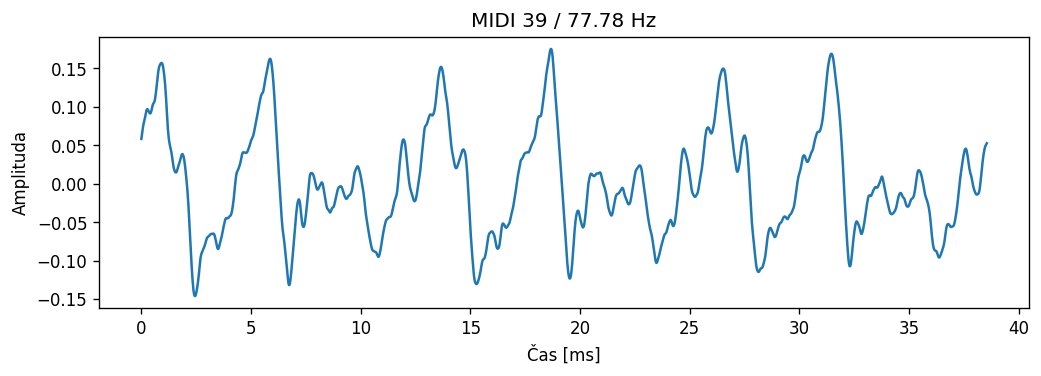

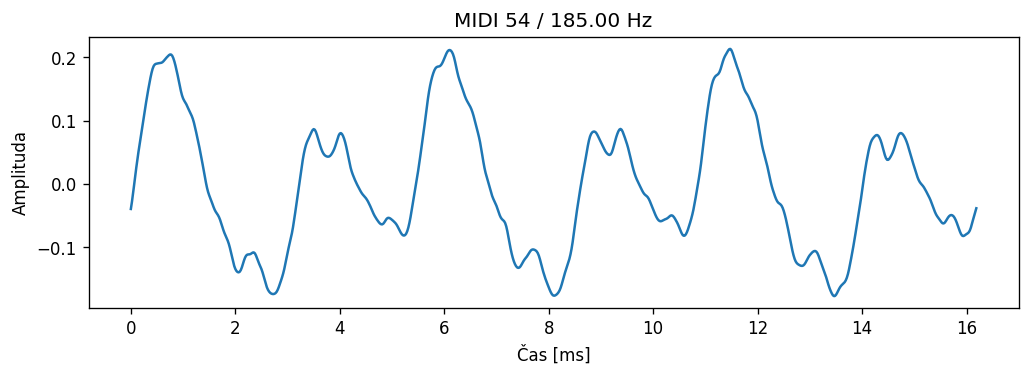

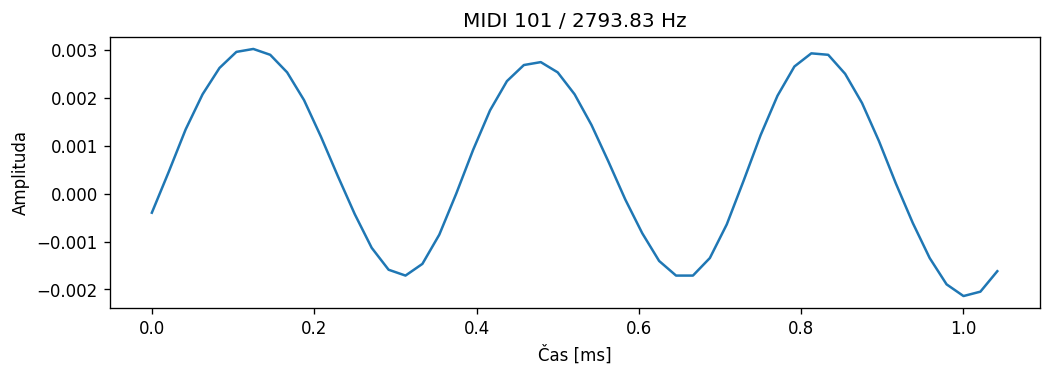

In [6]:
for (tone, freq) in xkucha28:
    three_periods = int(Fs / freq * 3)
    plt.figure(figsize=(10, 3), dpi=120)
    plt.plot(1000 * np.arange(0, three_periods) / Fs, xall[tone, :three_periods])
    plt.title(f"MIDI {tone} / {freq:.2f} Hz")
    plt.xlabel("Čas [ms]")
    plt.ylabel("Amplituda")

## Spočítání a zobrazení DFT
Pomocí numpy spočítáme DFT pro každý signál. K signálu jsem podle zadání pryčetl konstantu $10^{-5}$, aby se dalo spektrum pěkně zobrazit.

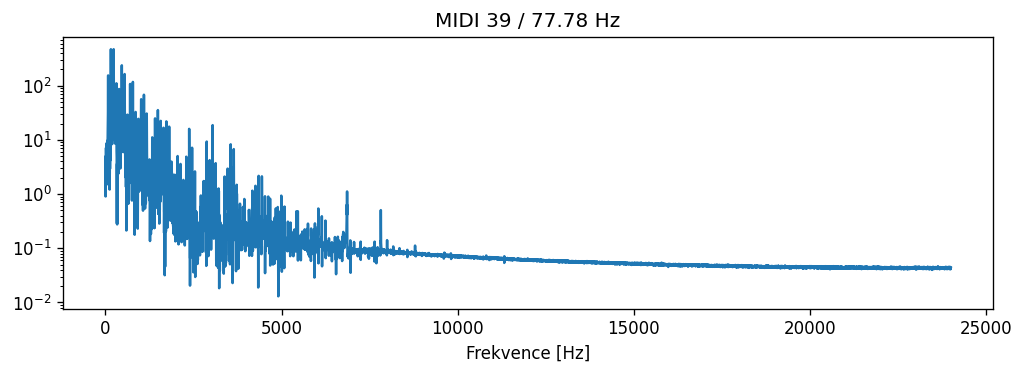

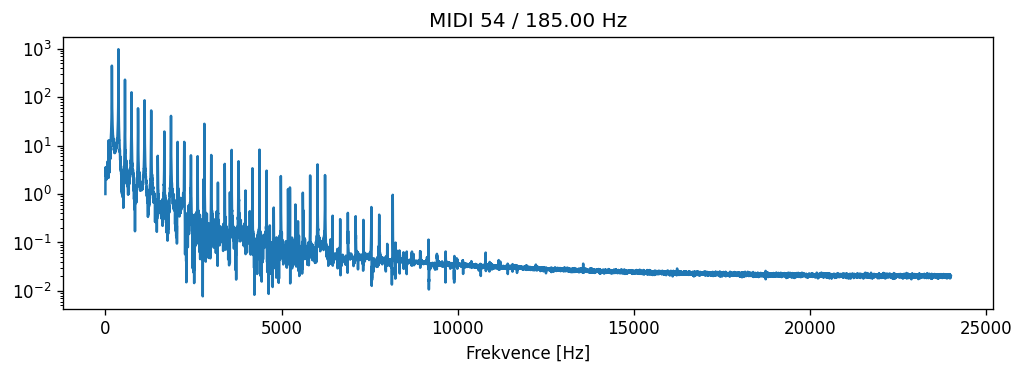

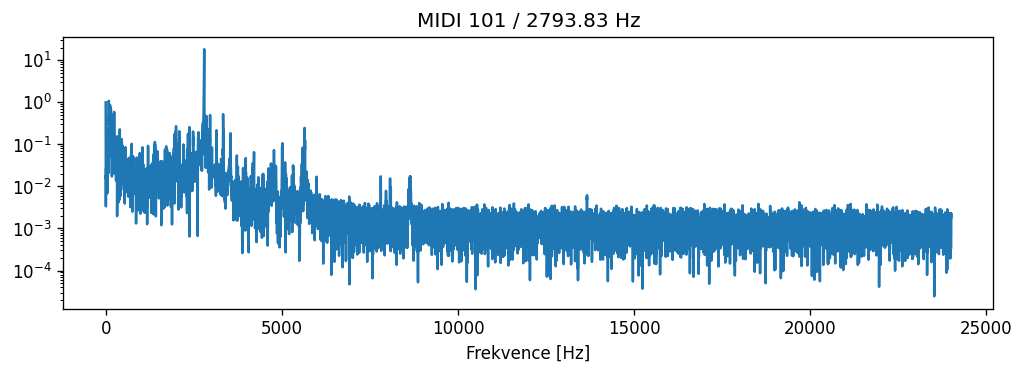

In [7]:
for (tone, freq) in xkucha28:
    fft = np.abs(np.fft.fft(xall[tone]))
    fft[0] += 1  # to avoid log(0), todo do this properly
    plt.figure(figsize=(10, 3), dpi=120)
    plt.plot(np.arange(0, Fs / 2, 2), fft[:len(fft)//2])
    plt.yscale('log')
    plt.title(f"MIDI {tone} / {freq:.2f} Hz")
    plt.xlabel("Frekvence [Hz]")


## Uložení tónů
Zadané tony uložíme pomocí knihovny soundfile.

In [8]:
names = ['a', 'b', 'c']
for i, (tone, _) in enumerate(xkucha28):
    sf.write(f'../audio/{names[i]}_orig.wav', xall[tone], Fs)

# Určení základní frekvence
Pro určení základní frekvence pro každý tón jsem použil dvě metody. Pro frekvence do 800Hz jsem použil autokorelaci a pro frekvence nad 800Hz jsem použil DFT. Jak zadání napovídá, tak autokorelace selhávala při vyšších frekvencích (vycházela například poloviční frekvence). Hranici 800Hz jsem zjistil experimentálně.

In [7]:
data = []
estimates = np.zeros(MIDITO + 1)
for tone, freq in midi.iterrows():
    f = 0
    if freq['freq'] < 800:
        c = np.correlate(xall[tone], xall[tone], mode='full')
        c = c[len(c)//2:]
        d = np.diff(c)
        start = np.nonzero(d > 0)[0][0]
        peak = np.argmax(c[start:]) + start
        f = Fs / peak
    else:
        fft = np.abs(np.fft.fft(xall[tone]))
        fft = fft[:len(fft)//2]
        f = np.argmax(fft) * 2
    data.append([f, freq['freq'], 100 * abs(f - freq['freq']) / freq['freq']])
    estimates[tone] = f
df1 = pd.DataFrame(data=data, columns=['Calculated', 'Expected', 'Error %'])

## Chyba při prvotním určení frekvence
Zde je tabulka se statistikou chyby napříč všemi frekvencemi. Dle mého je prvotní odhad frekvence velice slušný (Průměrná chyba 0.2%, maximální chyba 0.5%). TODO popsání vzniku chyby

In [23]:
df['Error %'].describe()

count    85.000000
mean      0.211914
std       0.147105
min       0.023285
25%       0.068920
50%       0.195465
75%       0.334238
max       0.544617
Name: Error %, dtype: float64

# Zpřesnění odhadu základní frekvence $f_0$

55.592828225189656


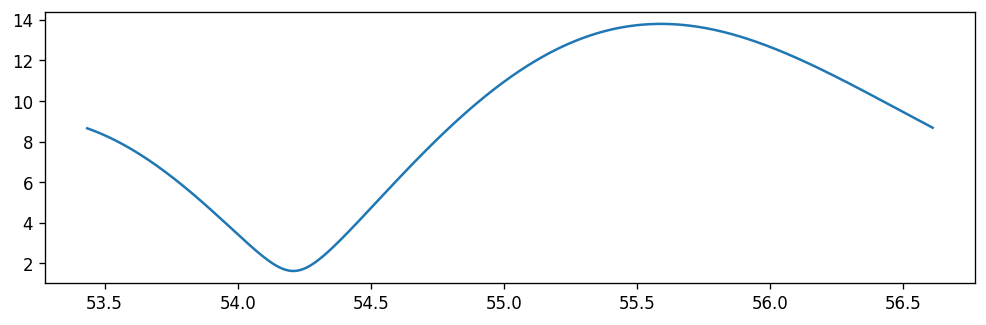

In [33]:
data = []
hundred_cent = 2**(50/1200)
for tone, freq in midi.iterrows():
    if (freq['freq'] != 55):
        continue
    FREQPOINTS = 500
    N = int(Fs / 2)
    n = np.arange(0, N)
    start = freq['freq'] / hundred_cent
    end = freq['freq'] * hundred_cent
    fsweep = np.linspace(start, end, FREQPOINTS)
    A = np.zeros([FREQPOINTS, N], dtype=complex)
    for k in np.arange(0, FREQPOINTS):
        A[k, :] = np.exp(-1j * 2 * np.pi * fsweep[k] / Fs * n)
    Xdtft = np.matmul(A, xall[tone].T)

    plt.figure(figsize=(10, 3), dpi=120)
    plt.plot(fsweep, np.abs(Xdtft))

    f = fsweep[np.argmax(np.abs(Xdtft))]
    print(f)
    data.append([f, freq['freq'], 100 * abs(f - freq['freq']) / freq['freq']])
df = pd.DataFrame(data=data, columns=['Calculated', 'Expected', 'Error %'])


In [34]:
print(df['Expected'][df['Error %'].idxmax()])
print(df['Calculated'][df['Error %'].idxmax()])


55.0
55.592828225189656


# Reprezentace klavíru


In [14]:
representation = []
for i in range(0, len(estimates)):
    representation.append(0)

# Calculate DTFT for all tones
for tone, freq in midi.iterrows():
    if (tone != 55):
        continue
    
    current = []
    print(tone)
    # k * f0, k = 1 .. 5
    for k in range(1, 6):
        omega = 2 * np.pi * k * estimates[tone] / Fs
        sum = 0
        for n in range(0, int(Fs / 2)):
            sum += xall[tone][n] * np.exp(-1j * omega * n)
        current.append((np.abs(sum), np.angle(sum)))
    representation[tone] = current

108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36


KeyboardInterrupt: 

In [15]:
representation[55]

[(445.6688293000017, -2.8646912663918873),
 (571.0631569919451, -0.3842204214370746),
 (102.81327815004504, -1.6506691477330941),
 (57.756267680449994, 1.5988436190011064),
 (24.50369797287219, 1.744073164121674)]

[    0     1     2 ... 47997 47998 47999]


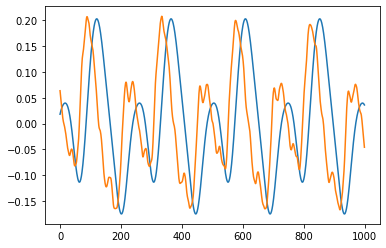

In [55]:
import math

test = []
repre = representation[55]


print(np.arange(0, Fs))

for n in range(0, int(Fs / 2)):
    sum = 0
    for k in range(0, 5):
        # omega = 2 * np.pi * (k+1) * estimates[55] / (Fs / 2)
        # a = repre[k][0] * np.exp(1j * repre[k][1])
        # sum += a * np.exp(1j * omega * n)
        sum += (repre[k][0] / (Fs/2)) * math.cos(2 * np.pi * (k+1) * estimates[55] / Fs * n + repre[k][1])
    #sum *= 1 / (Fs / 2)
    test.append(sum*5)
test
plt.plot(test[:1000])
plt.plot(xall[55][:1000])


# Syntéza tónů

# Generování hudby

## Načtení `skladba.txt`
Pro načtení `skladba.txt` jsem použil opět knihovnu Pandas.

In [100]:
song = pd.read_csv(open('skladba.txt', 'r'), sep=' ',
                       header=None, names=['from', 'to', 'midi', 'volume'])


TODO

# Spektogram
TODO